**NOTE**: this notebook has extra requirements, install them with: ```pip install "error_parity[dev]"```

**DATA**: the data used in this notebook can be easily downloaded and parsed using the companion notebook `parse-folktables-datasets.ipynb`;

In [1]:
import logging
from itertools import product
from pathlib import Path

import pandas as pd
import numpy as np
import cvxpy as cp
from scipy.spatial import ConvexHull
from sklearn.metrics import roc_curve

## Given some data (X, Y, S)

In [2]:
ACS_TASK = "ACSIncome"
SEED = 42

data_dir = Path("~").expanduser() / "data" / "folktables" / "train=0.7_test=0.3"

In [3]:
ACS_CATEGORICAL_COLS = {
    'COW',  # class of worker
    'MAR',  # marital status
    'OCCP', # occupation code
    'POBP', # place of birth code
    'RELP', # relationship status
    'SEX',
    'RAC1P', # race code
    'DIS',  # disability
    'ESP',  # employment status of parents
    'CIT',  # citizenship status
    'MIG',  # mobility status
    'MIL',  # military service
    'ANC',  # ancestry
    'NATIVITY',
    'DEAR',
    'DEYE',
    'DREM',
    'ESR',
    'ST',
    'FER',
    'GCL',
    'JWTR',
#     'PUMA',
#     'POWPUMA',
}

In [4]:
import folktables

def split_X_Y_S(data, label_col: str, sensitive_col: str, ignore_cols=None, unawareness=False) -> tuple:
    ignore_cols = ignore_cols or []
    ignore_cols.append(label_col)
    if unawareness:
        ignore_cols.append(sensitive_col)
    
    feature_cols = [c for c in data.columns if c not in ignore_cols]
    
    return (
        data[feature_cols],                           # X
        data[label_col].to_numpy().astype(int),       # Y
        data[sensitive_col].to_numpy().astype(int),   # S
    )

def load_ACS_data(dir_path: str, task_name: str, sensitive_col: str = None) -> pd.DataFrame:
    """Loads the given ACS task data from pre-generated datasets.

    Returns
    -------
    dict[str, tuple]
        A list of tuples, each tuple composed of (features, label, sensitive_attribute).
        The list is sorted as follows" [<train data tuple>, <test data tuple>, <val. data tuple>].
    """
    # Load task object
    task_obj = getattr(folktables, task_name)

    # Load train, test, and validation data
    data = dict()
    for data_type in ['train', 'test', 'validation']:
        # Construct file path
        path = Path(dir_path) / f"{task_name}.{data_type}.csv"
        
        if not path.exists():
            print(f"Couldn't find data for '{path.name}' (this is probably expected).")
            continue

        # Read data from disk
        df = pd.read_csv(path, index_col=0)

        # Set categorical columns
        cat_cols = ACS_CATEGORICAL_COLS & set(df.columns)
        df = df.astype({col: "category" for col in cat_cols})
        
        data[data_type] = split_X_Y_S(
            df,
            label_col=task_obj.target,
            sensitive_col=sensitive_col or task_obj.group,
        )

    return data

In [5]:
# Load and pre-process data
all_data = load_ACS_data(
    dir_path=data_dir, task_name=ACS_TASK,
)

# Unpack into features, label, and group
X_train, y_train, s_train = all_data["train"]
X_test, y_test, s_test = all_data["test"]
if "validation" in all_data:
    X_val, y_val, s_val = all_data["validation"]
else:
    print("No validation data.")

Couldn't find data for 'ACSIncome.validation.csv' (this is probably expected).
No validation data.


In [6]:
n_groups = len(np.unique(s_train))

In [7]:
actual_prevalence = np.sum(y_train) / len(y_train)
print(f"Global prevalence: {actual_prevalence:.1%}")

Global prevalence: 36.9%


In [8]:
EPSILON_TOLERANCE = 0.05
# EPSILON_TOLERANCE = 1.0  # best unconstrained classifier
FALSE_POS_COST = 1
FALSE_NEG_COST = 1

---
## Given a trained predictor (that outputs real-valued scores)

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_jobs=-2)

In [10]:
%%time
rf_clf.fit(X_train, y_train)

CPU times: user 2min 14s, sys: 2.51 s, total: 2min 17s
Wall time: 17.3 s


RandomForestClassifier(n_jobs=-2)

In [11]:
predictor = lambda X: rf_clf.predict_proba(X)[:, -1]

## Construct the fair optimal classifier (derived from the given predictor)
- Fairness is measured by the equal odds constraint (equal FPR and TPR among groups);
    - optionally, this constraint can be relaxed by some small tolerance;
- Optimality is measured as minimizing the expected loss,
    - parameterized by the given cost of false positive and false negative errors;

In [12]:
from error_parity import RelaxedThresholdOptimizer

clf = RelaxedThresholdOptimizer(
    predictor=predictor,
    constraint="equalized_odds",
    tolerance=EPSILON_TOLERANCE,
    false_pos_cost=FALSE_POS_COST,
    false_neg_cost=FALSE_NEG_COST,
    max_roc_ticks=1000,
    seed=SEED,
)

In [13]:
# Set data for fitting equal odds
# > fit on train or test or validation?
X, y_true, group = X_test, y_test, s_test
# X, y_true, group = X_train, y_train, s_train

In [14]:
%%time
import logging
logging.basicConfig(level=logging.INFO, force=True)
clf.fit(X=X, y=y_true, group=group)

INFO:root:ROC convex hull contains 9.8% of the original points.
INFO:root:ROC convex hull contains 7.9% of the original points.
INFO:root:ROC convex hull contains 17.5% of the original points.
INFO:root:ROC convex hull contains 18.2% of the original points.
INFO:root:ROC convex hull contains 17.0% of the original points.
INFO:root:ROC convex hull contains 5.9% of the original points.
INFO:root:ROC convex hull contains 18.3% of the original points.
INFO:root:ROC convex hull contains 10.0% of the original points.
INFO:root:ROC convex hull contains 16.8% of the original points.
INFO:root:cvxpy solver took 0.001169s; status is optimal.
INFO:root:Optimal solution value: 0.19933529995635396
INFO:root:Variable Global ROC point: value [0.13538843 0.6910556 ]
INFO:root:Variable ROC point for group 0: value [0.14000413 0.69554714]
INFO:root:Variable ROC point for group 1: value [0.11771849 0.64554714]
INFO:root:Variable ROC point for group 2: value [0.15981902 0.64554714]
INFO:root:Variable ROC 

CPU times: user 24.5 s, sys: 303 ms, total: 24.8 s
Wall time: 3.36 s


## Plot solution

In [15]:
group_name_map = {
    0: "White",
    1: "Black",
    2: "American Indian",
    3: "Alaska Native",
    4: "American Indian",
    5: "Asian",
    6: "Native Hawaiian",
    7: "other single race",
    8: "other multiple races",
}

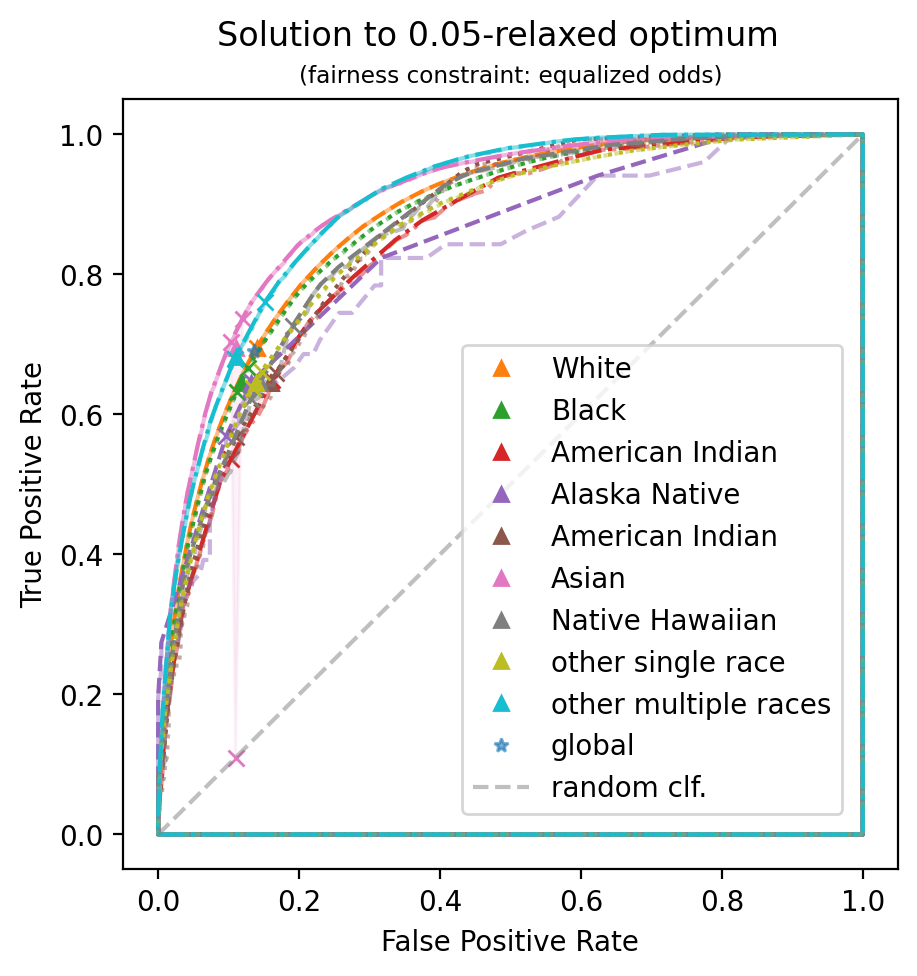

In [16]:
from matplotlib import pyplot as plt
clf.plot(
    plot_roc_curves=True,
    plot_roc_hulls=True,
    dpi=200, figsize=(5, 5),
    group_name_map=group_name_map,
)
plt.show()

#### Theoretical results:

In [17]:
acc_val = 1 - clf.cost(1.0, 1.0)
unf_val = clf.constraint_violation()

print(f"Accuracy:   {acc_val:.1%}")
print(f"Unfairness: {unf_val:.1%} <= {EPSILON_TOLERANCE:.1%}")

INFO:root:Maximum fairness violation is between group=2 (p=[0.15981902 0.64554714]) and group=5 (p=[0.10981902 0.69554714]);


Accuracy:   80.1%
Unfairness: 5.0% <= 5.0%


---
## Plot realized ROC points
> realized ROC points will converge to the theoretical solution for larger datasets, but some variance is expected for smaller datasets

In [18]:
# Set group-wise colors and global color
import seaborn as sns
sns.set(style="whitegrid")
palette = sns.color_palette(n_colors=n_groups + 1)
global_color = palette[0]
all_group_colors = palette[1:]

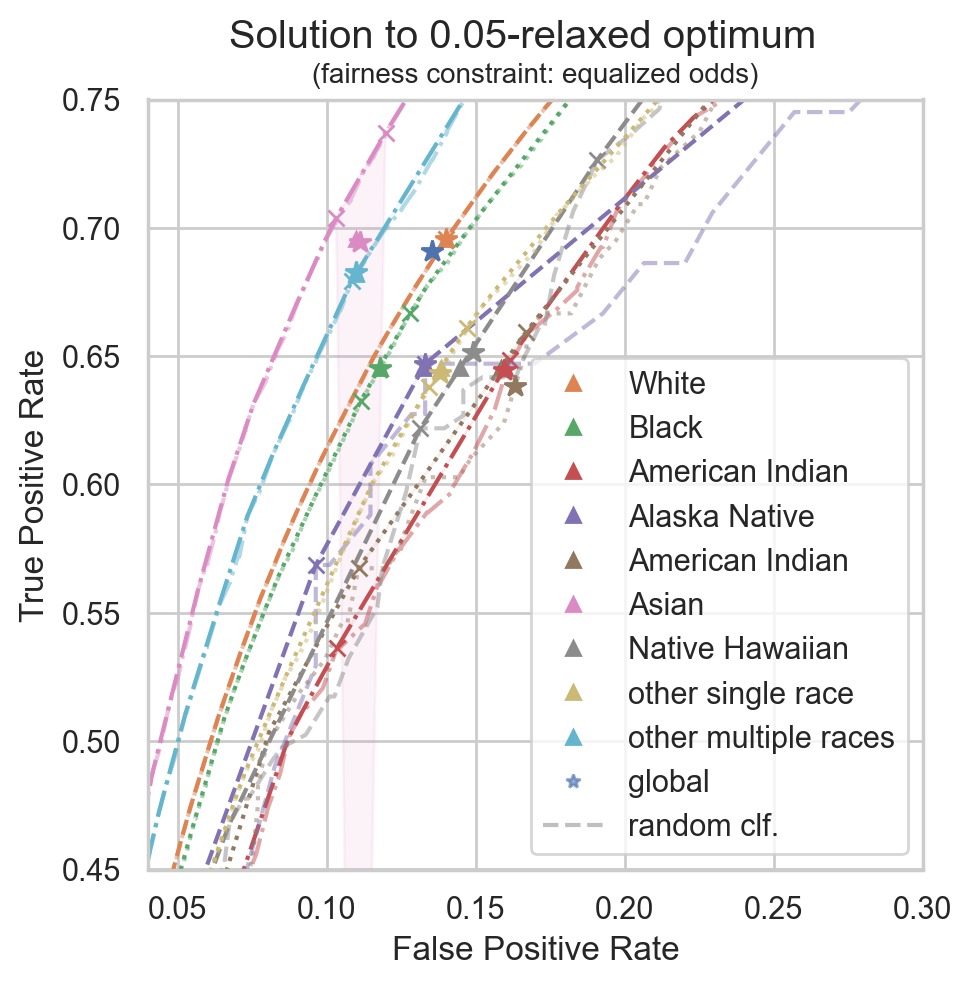

In [19]:
from error_parity.roc_utils import compute_roc_point_from_predictions

clf.plot(
    plot_roc_curves=True,
    plot_roc_hulls=True,
    dpi=200, figsize=(5, 5),
    group_name_map=group_name_map,
)

# Compute predictions
y_pred_binary = clf(X, group=group)

# Plot the group-wise points found
realized_roc_points = list()
for idx in range(n_groups):

    # Evaluate triangulation of target point as a randomized clf
    group_filter = group == idx

    curr_realized_roc_point = compute_roc_point_from_predictions(y_true[group_filter], y_pred_binary[group_filter])
    realized_roc_points.append(curr_realized_roc_point)

    plt.plot(
        curr_realized_roc_point[0], curr_realized_roc_point[1],
        color=all_group_colors[idx],
        marker="*", markersize=8,
        lw=0,
    )

realized_roc_points = np.vstack(realized_roc_points)

# Plot actual global classifier performance
global_clf_realized_roc_point = compute_roc_point_from_predictions(y_true, y_pred_binary)
plt.plot(
    global_clf_realized_roc_point[0], global_clf_realized_roc_point[1],
    color=global_color,
    marker="*", markersize=8,
    lw=0,
)


plt.xlim(0.04, 0.3)
plt.ylim(0.45, 0.75)
plt.legend()


plt.show()

### Compute distances between theorized ROC points and empirical ROC points

In [20]:
# Distances to group-wise targets:
for i, (target_point, actual_point) in enumerate(zip(clf.groupwise_roc_points, realized_roc_points)):
    dist = np.linalg.norm(target_point - actual_point, ord=2)
    print(f"Group {i}: l2 distance from target to realized point := {dist:.3%} (size={np.sum(group==i)})")

# Distance to global target point:
dist = np.linalg.norm(clf.global_roc_point - global_clf_realized_roc_point, ord=2)
print(f"Global l2 distance from target to realized point   := {dist:.3%}")

Group 0: l2 distance from target to realized point := 0.000% (size=389168)
Group 1: l2 distance from target to realized point := 0.017% (size=44387)
Group 2: l2 distance from target to realized point := 0.088% (size=3550)
Group 3: l2 distance from target to realized point := 0.167% (size=269)
Group 4: l2 distance from target to realized point := 0.870% (size=674)
Group 5: l2 distance from target to realized point := 0.148% (size=28899)
Group 6: l2 distance from target to realized point := 0.749% (size=825)
Group 7: l2 distance from target to realized point := 0.214% (size=19036)
Group 8: l2 distance from target to realized point := 0.071% (size=12542)
Global l2 distance from target to realized point   := 0.012%


### Compute performance differences
> assumes FP_cost == FN_cost == 1.0

In [21]:
from sklearn.metrics import accuracy_score
from error_parity.roc_utils import calc_cost_of_point

# Empirical accuracy
accuracy_val = accuracy_score(y_true, y_pred_binary)

print(f"Actual accuracy: \t\t{accuracy_val:.3%}")
print(f"Actual error rate (1 - Acc.):\t{1 - accuracy_val:.3%}")
print(f"Theoretical error rate:\t\t{clf.cost(1.0, 1.0):.3%}")

Actual accuracy: 		80.058%
Actual error rate (1 - Acc.):	19.942%
Theoretical error rate:		19.934%


---

### Best non-fairness-constrained single-threshold solution --- RESULTS ON *TEST DATA*

In [22]:
from tqdm.auto import tqdm
y_pred_scores = predictor(X)
acc_unfair = max((accuracy_score(y_true, y_pred_scores >= t), t) for t in tqdm(np.arange(0, 1, 2e-2)))
acc_unfair_val, acc_unfair_thrs = acc_unfair
print(f"Best (train) unfair accuracy is {acc_unfair_val:.3%}, with threshold t={acc_unfair_thrs}")

  0%|          | 0/50 [00:00<?, ?it/s]

Best (train) unfair accuracy is 80.368%, with threshold t=0.52


In [23]:
def eval_accuracy_fairness(y_true, y_pred_binary, group, display=True):
    roc_points = [
        compute_roc_point_from_predictions(
            y_true[group == i],
            y_pred_binary[group == i])
        for i in range(n_groups)
    ]

    roc_points = np.vstack(roc_points)

    linf_constraint_violation = [
        np.linalg.norm(roc_points[i] - roc_points[j], ord=np.inf)
        for i, j in product(range(n_groups), range(n_groups))
        if i < j
    ]

    acc_val = accuracy_score(y_true, y_pred_binary)
    fairness_violation = max(linf_constraint_violation)
    
    if display:
        print(f"\tAccuracy:   {acc_val:.2%}")
        print(f"\tUnfairness: {fairness_violation:.2%}")

    return (acc_val, fairness_violation)

In [24]:
print("Best (unconstrained) single-threshold classifier:")
eval_accuracy_fairness(
    y_true=y_test,
    y_pred_binary=predictor(X_test) >= acc_unfair_thrs,
    group=s_test)

print("Best (constrained) multi-threshold classifier:")
eval_accuracy_fairness(
    y_true=y_test,
    y_pred_binary=clf(X_test, group=s_test),
    group=s_test);

Best (unconstrained) single-threshold classifier:
	Accuracy:   80.37%
	Unfairness: 47.84%
Best (constrained) multi-threshold classifier:
	Accuracy:   80.07%
	Unfairness: 5.10%


## Fairness vs Performance trade-off

In [25]:
def train_error_parity(tolerance: float):

    clf = RelaxedThresholdOptimizer(
        predictor=predictor,
        constraint="equalized_odds",
        tolerance=tolerance,
        false_pos_cost=FALSE_POS_COST,
        false_neg_cost=FALSE_NEG_COST,
        max_roc_ticks=1000,
        seed=SEED,
    )

    logging.basicConfig(level=logging.WARNING, force=True)
    clf.fit(X=X, y=y_true, group=group)
    
    # Test results
    y_pred_binary = clf(X_test, group=s_test)
    
    return eval_accuracy_fairness(
        y_true=y_test,
        y_pred_binary=y_pred_binary,
        group=s_test,
        display=False,
    )

In [26]:
fair_perf_tradeoff = {
    tol: train_error_parity(tol)
    for tol in tqdm(np.arange(0, 1, 5e-2))
}

  0%|          | 0/20 [00:00<?, ?it/s]

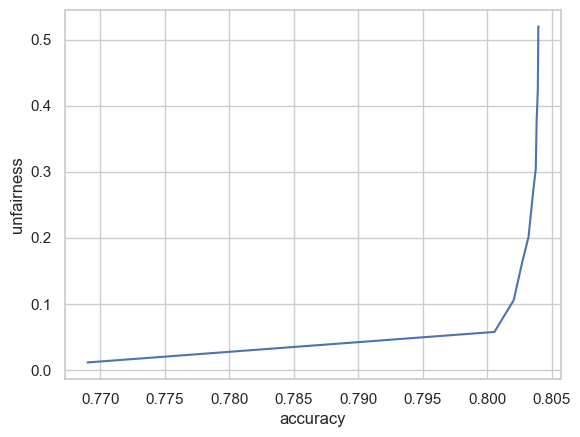

In [27]:
# Plot results
import seaborn as sns
sns.set(style="whitegrid")

data = pd.DataFrame(
    data=[
        (acc, unf, tol)
        for tol, (acc, unf) in fair_perf_tradeoff.items()
    ],
    columns=["accuracy", "unfairness", "tolerance"])

sns.lineplot(
    data,
    x="accuracy",
    y="unfairness",
)

plt.show()

---